# Toxic comments

This notebook takes you though a complete iteration of Machine Learning Assignment 1 - Toxic comments. The assignment details (including links to download the data) can be found [here](https://docs.google.com/document/d/1WGYw99e5q6j5V0Zrf2HveagU6URt_kVvdR8B9HYQ99E/edit?usp=sharing). 

In [1]:
# all imports and magic commands
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from my_measures import BinaryClassificationPerformance
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from scipy.sparse import csr_matrix, hstack
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
%matplotlib inline

### IMPORTANT!!! Make sure you are using `BinaryClassificationPerformance` v1.02

In [2]:
help(BinaryClassificationPerformance)

Help on class BinaryClassificationPerformance in module my_measures:

class BinaryClassificationPerformance(builtins.object)
 |  BinaryClassificationPerformance(predictions, labels, desc, probabilities=None)
 |  
 |  Performance measures to evaluate the fit of a binary classification model, v1.02
 |  
 |  Methods defined here:
 |  
 |  __init__(self, predictions, labels, desc, probabilities=None)
 |      Initialize attributes: predictions-vector of predicted values for Y, labels-vector of labels for Y
 |  
 |  compute_measures(self)
 |      Compute performance measures defined by Flach p. 57
 |  
 |  img_indices(self)
 |      Get the indices of true and false positives to be able to locate the corresponding images in a list of image names
 |  
 |  ----------------------------------------------------------------------
 |  Data descriptors defined here:
 |  
 |  __dict__
 |      dictionary for instance variables (if defined)
 |  
 |  __weakref__
 |      list of weak references to the obj

# Function for feature building and extraction on natural language data

In [3]:
# function that takes raw data and completes all preprocessing required before model fits
def process_raw_data(fn, my_random_seed, test=False):
    # read and summarize data
    toxic_data = pd.read_csv(fn)
    if (not test):
        # add an indicator for any toxic, severe toxic, obscene, threat, insult, or indentity hate
        toxic_data['any_toxic'] = (toxic_data['toxic'] + toxic_data['severe_toxic'] + toxic_data['obscene'] + toxic_data['threat'] + toxic_data['insult'] + toxic_data['identity_hate'] > 0)
    print("toxic_data is:", type(toxic_data))
    print("toxic_data has", toxic_data.shape[0], "rows and", toxic_data.shape[1], "columns", "\n")
    print("the data types for each of the columns in toxic_data:")
    print(toxic_data.dtypes, "\n")
    print("the first 10 rows in toxic_data:")
    print(toxic_data.head(5))
    if (not test):
        print("The rate of 'toxic' Wikipedia comments in the dataset: ")
        print(toxic_data['any_toxic'].mean())

    # vectorize Bag of Words from review text; as sparse matrix
    if (not test): # fit_transform()
        hv = HashingVectorizer( n_features=2 ** 15, alternate_sign=False, strip_accents='ascii', lowercase=True, ngram_range=(1,3))
        
        
        
        ## 3 changes. strip accents, lowercase, ngram_range,  ## 
        
        #CUT FROM ORIGINAL: 
        #n_features=2 ** 17, 
        ## n_features=2 ** 16
        ### ngram_range(1,3)
        
        X_hv = hv.fit_transform(toxic_data.comment_text)
        fitted_transformations.append(hv)
        print("Shape of HashingVectorizer X:")
        print(X_hv.shape)
    else: # transform() 
        X_hv = fitted_transformations[0].transform(toxic_data.comment_text)
        print("Shape of HashingVectorizer X:")
        print(X_hv.shape)
    
    # http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html
    if (not test):
        transformer = TfidfTransformer()
        X_tfidf = transformer.fit_transform(X_hv)
        fitted_transformations.append(transformer)
    else:
        X_tfidf = fitted_transformations[1].transform(X_hv)
    
    # create additional quantitative features
   
    toxic_data['word_count'] = toxic_data['comment_text'].str.split(' ').str.len()
    toxic_data['punc_count'] = toxic_data['comment_text'].str.count("\.")
   # toxic_data['case_count'] = toxic_data['comment_text'].str.split(' ').str.isupper()
    toxic_data['punc_count2'] = toxic_data['comment_text'].str.count("\!")
    ####new columns here 
    toxic_data['upper_case'] = toxic_data['comment_text'].str.count(r'[A-Z]')
    
    

    X_quant_features = toxic_data[["word_count", "punc_count", "punc_count2", "upper_case"]]
    
    #####
    
    print("Look at a few rows of the new quantitative features: ")
    print(X_quant_features.head(10))
    
    # Combine all quantitative features into a single sparse matrix
    X_quant_features_csr = csr_matrix(X_quant_features)
    X_combined = hstack([X_tfidf, X_quant_features_csr])
    X_matrix = csr_matrix(X_combined) # convert to sparse matrix
    print("Size of combined bag of words and new quantitative variables matrix:")
    print(X_matrix.shape)
    
    # Create `X`, scaled matrix of features
    # feature scaling
    if (not test):
        sc = StandardScaler(with_mean=False)
        X = sc.fit_transform(X_matrix)
        fitted_transformations.append(sc)
        print(X.shape)
        y = toxic_data['any_toxic']
    else:
        X = fitted_transformations[2].transform(X_matrix)
        print(X.shape)
    
    # Create Training and Test Sets
    # enter an integer for the random_state parameter; any integer will work
    if (test):
        X_submission_test = X
        print("Shape of X_test for submission:")
        print(X_submission_test.shape)
        print('SUCCESS!')
        return(toxic_data, X_submission_test)
    else: 
        X_train, X_test, y_train, y_test, X_raw_train, X_raw_test = train_test_split(X, y, toxic_data, test_size=0.2, random_state=my_random_seed)
        print("Shape of X_train and X_test:")
        print(X_train.shape)
        print(X_test.shape)
        print("Shape of y_train and y_test:")
        print(y_train.shape)
        print(y_test.shape)
        print("Shape of X_raw_train and X_raw_test:")
        print(X_raw_train.shape)
        print(X_raw_test.shape)
        print('SUCCESS!')
        return(X_train, X_test, y_train, y_test, X_raw_train, X_raw_test)

# Create training and test sets from function

In [4]:
# create an empty list to store any use of fit_transform() to transform() later
# it is a global list to store model and feature extraction fits
fitted_transformations = []

# CHANGE FILE PATH and my_random_seed number (any integer other than 74 will do): 
X_train, X_test, y_train, y_test, X_raw_train, X_raw_test = process_raw_data(fn='C:/Users/Dallas/Desktop/Machine Learning/toxiccomments_train.csv', my_random_seed=85)

print("Number of fits stored in `fitted_transformations` list: ")
print(len(fitted_transformations))

toxic_data is: <class 'pandas.core.frame.DataFrame'>
toxic_data has 159571 rows and 9 columns 

the data types for each of the columns in toxic_data:
id               object
comment_text     object
toxic             int64
severe_toxic      int64
obscene           int64
threat            int64
insult            int64
identity_hate     int64
any_toxic          bool
dtype: object 

the first 10 rows in toxic_data:
                 id                                       comment_text  toxic  \
0  0000997932d777bf  Explanation\nWhy the edits made under my usern...      0   
1  000103f0d9cfb60f  D'aww! He matches this background colour I'm s...      0   
2  000113f07ec002fd  Hey man, I'm really not trying to edit war. It...      0   
3  0001b41b1c6bb37e  "\nMore\nI can't make any real suggestions on ...      0   
4  0001d958c54c6e35  You, sir, are my hero. Any chance you remember...      0   

   severe_toxic  obscene  threat  insult  identity_hate  any_toxic  
0             0        0     

# Fit (and tune) Various Models

### MODEL: ordinary least squares

In [5]:
from sklearn import linear_model
ols = linear_model.SGDClassifier(loss="squared_loss")
ols.fit(X_train, y_train)

ols_performance_train = BinaryClassificationPerformance(ols.predict(X_train), y_train, 'ols_train')
ols_performance_train.compute_measures()
print(ols_performance_train.performance_measures)

{'Pos': 12979, 'Neg': 114677, 'TP': 6179, 'TN': 59674, 'FP': 55003, 'FN': 6800, 'Accuracy': 0.5158629441624365, 'Precision': 0.10099375633356215, 'Recall': 0.47607673934817785, 'desc': 'ols_train'}


C:\Users\Dallas\anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:570: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "


### MODEL: SVM, linear

In [6]:
from sklearn import linear_model
svm = linear_model.SGDClassifier()
svm.fit(X_train, y_train)

svm_performance_train = BinaryClassificationPerformance(svm.predict(X_train), y_train, 'svm_train')
svm_performance_train.compute_measures()
print(svm_performance_train.performance_measures)

{'Pos': 12979, 'Neg': 114677, 'TP': 12944, 'TN': 114643, 'FP': 34, 'FN': 35, 'Accuracy': 0.9994594848655762, 'Precision': 0.9973801818462013, 'Recall': 0.9973033361584097, 'desc': 'svm_train'}


In [27]:
### MODEL: SVM, linearSVC

In [7]:
# class sklearn.svm.LinearSVC(penalty='l2', loss='squared_hinge', *, dual=True, tol=0.0001, 
#C=1.0, multi_class='ovr', fit_intercept=True, 
#intercept_scaling=1, class_weight=None, verbose=0, random_state=None, max_iter=1000)

from sklearn.svm import LinearSVC
svc = LinearSVC(C=.0001, max_iter=100000)
svc.fit(X_train, y_train)
svc_performance_train = BinaryClassificationPerformance(svc.predict(X_train), y_train, 'svc_train-c=.0001')
svc_performance_train.compute_measures()
print(svc_performance_train.performance_measures)

{'Pos': 12979, 'Neg': 114677, 'TP': 12485, 'TN': 114611, 'FP': 66, 'FN': 494, 'Accuracy': 0.9956132105032274, 'Precision': 0.9947414548641542, 'Recall': 0.9619385160644117, 'desc': 'svc_train-c=.0001'}


### MODEL: logistic regression

In [8]:
from sklearn import linear_model
lgs = linear_model.SGDClassifier(loss='log')
lgs.fit(X_train, y_train)

lgs_performance_train = BinaryClassificationPerformance(lgs.predict(X_train), y_train, 'lgs_train')
lgs_performance_train.compute_measures()
print(lgs_performance_train.performance_measures)

{'Pos': 12979, 'Neg': 114677, 'TP': 12951, 'TN': 114665, 'FP': 12, 'FN': 28, 'Accuracy': 0.9996866578930876, 'Precision': 0.9990742883591761, 'Recall': 0.9978426689267278, 'desc': 'lgs_train'}


### MODEL: Naive Bayes

In [9]:
from sklearn.naive_bayes import MultinomialNB
nbs = MultinomialNB()
nbs.fit(X_train, y_train)

nbs_performance_train = BinaryClassificationPerformance(nbs.predict(X_train), y_train, 'nbs_train')
nbs_performance_train.compute_measures()
print(nbs_performance_train.performance_measures)

{'Pos': 12979, 'Neg': 114677, 'TP': 11503, 'TN': 102921, 'FP': 11756, 'FN': 1476, 'Accuracy': 0.8963464310334023, 'Precision': 0.49456124510942, 'Recall': 0.8862778334232221, 'desc': 'nbs_train'}


### MODEL: Perceptron

In [10]:
from sklearn import linear_model
prc = linear_model.SGDClassifier(loss='perceptron')
prc.fit(X_train, y_train)

prc_performance_train = BinaryClassificationPerformance(prc.predict(X_train), y_train, 'prc_train')
prc_performance_train.compute_measures()
print(prc_performance_train.performance_measures)

{'Pos': 12979, 'Neg': 114677, 'TP': 12907, 'TN': 114631, 'FP': 46, 'FN': 72, 'Accuracy': 0.9990756407846086, 'Precision': 0.9964486991430557, 'Recall': 0.9944525772401572, 'desc': 'prc_train'}


### MODEL: Ridge Regression Classifier

In [11]:
from sklearn import linear_model
rdg = linear_model.RidgeClassifier(5)
rdg.fit(X_train, y_train)

rdg_performance_train = BinaryClassificationPerformance(rdg.predict(X_train), y_train, 'rdg_train')
rdg_performance_train.compute_measures()
print(rdg_performance_train.performance_measures)

{'Pos': 12979, 'Neg': 114677, 'TP': 9493, 'TN': 114515, 'FP': 162, 'FN': 3486, 'Accuracy': 0.9714231998495958, 'Precision': 0.9832211289487313, 'Recall': 0.7314122813776099, 'desc': 'rdg_train'}


### MODEL: Random Forest Classifier

In [12]:
from sklearn.ensemble import RandomForestClassifier
rdf = RandomForestClassifier(max_depth=2, random_state=0)
rdf.fit(X_train, y_train)

rdf_performance_train = BinaryClassificationPerformance(rdf.predict(X_train), y_train, 'rdf_train')
rdf_performance_train.compute_measures()
print(rdf_performance_train.performance_measures)

{'Pos': 12979, 'Neg': 114677, 'TP': 0, 'TN': 114677, 'FP': 0, 'FN': 12979, 'Accuracy': 0.8983283198596227, 'Precision': nan, 'Recall': 0.0, 'desc': 'rdf_train'}


C:\Users\Dallas\Desktop\Machine Learning\final_assignment_1\my_measures.py:25: RuntimeWarning: invalid value encountered in longlong_scalars
  self.performance_measures['Precision'] = self.performance_measures['TP'] / (self.performance_measures['TP'] + self.performance_measures['FP'])


### ROC plot to compare performance of various models and fits

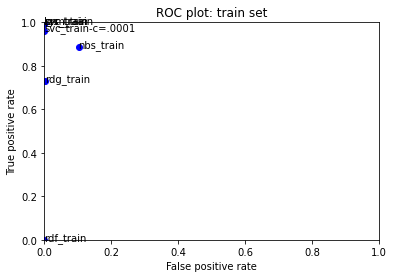

In [13]:
fits = [svc_performance_train, svm_performance_train, lgs_performance_train, nbs_performance_train, prc_performance_train, rdg_performance_train, rdf_performance_train]

for fit in fits:
    plt.plot(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], 'bo')
    plt.text(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], fit.desc)
plt.axis([0, 1, 0, 1])
plt.title('ROC plot: train set')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.show()

### looking at reviews based on their classification

Let's say we decide that Ordinary Least Squares (OLS) Regression is the best model for generalization. Let's take a look at some of the reviews and try to make a (subjective) determination of whether it's generalizing well. 

### let's look at some false positives:

In [14]:
ols_predictions = ols.predict(X_train)

In [15]:
# false positives

print("Examples of false positives:")

import random, time

for i in range(0, len(ols_predictions)):
    if (ols_predictions[i] == 1):
        if (X_raw_train.iloc[i]['any_toxic'] == 0):
            if (random.uniform(0, 1) < 0.05): # to print only 5% of the false positives
                print(i)
                print(X_raw_train.iloc[i]['comment_text'])
                print('* * * * * * * * * ')


Examples of false positives:
60
...also this is coming up
* * * * * * * * * 
101
in an interview before his execution
* * * * * * * * * 
176
"
Yes, cite ""all material that is challenged or likely to be challenged"". While you may disagree with , the edits ze made challenge the material. If the information has ""obviously been taken from the album itself"", cite the album itself. While it is a primary source (so appropriate cautions apply), it is a reliable source for basic, factual information. -   "
* * * * * * * * * 
233
I depersonalized the comment.  As for his sociopathy - you are entitled to your opinion.
* * * * * * * * * 
251
"
 Your request at Files for upload 
 Hello, and thank you for your request at Files for Upload! The file has been uploaded.  You can find it at File:Volney Davis.jpg. See Wikipedia:Images#Using images to learn image syntax, or Wikipedia:Creation and usage of media files for other types of files. Regards, ''''''''''  "
* * * * * * * * * 
591
"::::Hi. Can y

2659
Jingiby, why do you want to re-write Turkish people's history. Your so-called ethnogenesis part is not true as we know. My m-DNA tested in London, and i carry Asian gens, of course it may not for all Turkish peoples in the area but likely total number is Asian. So please dont vandalise Turks as a European or Middleeastern. By the way, arent you a Bulgarian? Start with yourself pls
* * * * * * * * * 
2804
"
I am really sorry about your relatives, but any reasonable person, as I know you are, should agree that the persecution of the Copts, the massacre in Luxor cannot be compared to a collapsed building. Copts are important part of Egyptian society. I am not saying that the whole section that you deleted should be included, but a few sentences should. Here's an extract from Speigel: ""Copts make up the largest Christian community in the Arab world and around 8 million Egyptians belong to the Coptic Church. They're barred from high government positions, diplomatic service and the mil

5016
Well yeah pop rock sums Avril Lavigne up very well but I just didn't feel that songs like Complicated and I'm With You were best described simply as pop rock. I thought they also had a softer feel...maybe pop wasn't the best way to describe them but can you see where I'm coming from? If you think they cause too many problems thn feel free to remove them
* * * * * * * * * 
5071
REDIRECT Talk:Zrkinyants Saint Gevork Church
* * * * * * * * * 
5078
Deleted Captureka 

Dear Fastily,

you deleted Captureka article and then you deleted a message about deletion in this forum too.
Please recover Captureka article. 
It has to be listed in Screenshot article in third-party tools as other are.
So if others are allowed to be mentioned I suppose such an article can not be treated as G11 (advertising).
If you have a problem with possible advertising, please consider that other tools are also listed in wikipedia and those articles are not treated as advertising. So have to be treated Captureka.
*

7296
NPOV
This article sounds like an advert written by the drug company itself...
There are no side effects,
No study texts
A link to the manofacturer website
And the technical language which usually appears in this kind of Advert.
* * * * * * * * * 
7303
Sorry, I have already said everything and have nothing more to add, at least to the listener of your kind.
* * * * * * * * * 
7426
"

The polemic article quoted makes mention of Wilberforce's mistress ""Agnes Bronte"". I think I have found the original website the information in this and other anti-Wilberforce essays comes from:

http://freespace.virgin.net/pr.og/agnes.html

This appears to be part of a spoof website with lots of spurious biographies of fictional Bronte family members but it has been taken as a serious source by people with an axe to grind.  "
* * * * * * * * * 
7502
As I wrote above, you guys are pushing on how Wikipedia deals with pseudoscience. The place to discuss that is NOT here, but rather on the relevant poli

9585
Not true. See The Hague versus Amsterdam.89.168.178.195
* * * * * * * * * 
9590
Do a little research yourself before you go around erasing things just because you like to censor.
* * * * * * * * * 
9677
crime of going on ANI)
* * * * * * * * * 
9740
Matt Hamill is an American wrestler turned MMA fighter. He was born in Cincinnati, Ohio and is deaf. He is also a contestant on the third season of The Ultimate Fighter reality television show. 

Among other achievements, he was a three-time NCAA National Champion National Technical Institute for the Deaf in Rochester, New York. 

Category:Athletes
Category:Wrestlers
* * * * * * * * * 
9754
Hello -  Welcome this is Bearbiggs
* * * * * * * * * 
9789
Jazzcat...Evolution is a theory in science, which means it's pretty a fact.  Creationism is an invention with no evidence whatsoever.  Don't create a false equivalence, because Evolution is real science and creationism is an invention necessary for uneducated Bronze Age goatherders.  It's a 

11407
"

 Please do not vandalize pages, as you did with this edit to Batcave. If you continue to do so, you will be blocked from editing.  Cheers. Trance addict - Armin van Buuren - Oceanlab "
* * * * * * * * * 
11542
"

Speedy deletion of 99boyz
 A tag has been placed on 99boyz requesting that it be speedily deleted from Wikipedia. This has been done under section A7 of the criteria for speedy deletion, because the article appears to be about a club, but it does not indicate how or why the subject is notable: that is, why an article about that subject should be included in an encyclopedia. Under the criteria for speedy deletion, articles that do not indicate the subject's importance or significance may be deleted at any time. Please see the guidelines for what is generally accepted as notable, as well as our subject-specific notability guidelines for people and for organizations. 

If you think that this notice was placed here in error, you may contest the deletion by adding  to the 

13626
was playing around on sandbox...how can you get in trouble on sand box????
* * * * * * * * * 
13650
"

 If we are not ""people"" what are we? Cattle? "
* * * * * * * * * 
13656
"

 Typo 

There's a pretty big mistake. In the infobox they call it ""the beautiful game.""  Someone must accidentally have used the word ""beautiful"" when they meant ""boring.""  Could someone please change this?  Thanks.  69.158.141.106  "
* * * * * * * * * 
13732
"
Yeah, OMG I saw it right now. Awesome, she is getting iconic. Yeah I saw ) I expected it. Also expected number 1 in Scotland, but ... Oh, alright, I will move it, let me just check first. ) — (T2ME) "
* * * * * * * * * 
13773
Wikipedia talk:Verifiability#Age of unreferenced
I made a post to Wikipedia talk:Verifiability#Age of unreferenced that you might be interested in.
* * * * * * * * * 
13843
"

  is wishing you a Merry Christmas! This greeting (and season) promotes WikiLove and hopefully this one has made your day a little better. Sprea

15492
What? 

Why do you have a problem with my legit edit?
* * * * * * * * * 
15520
Keep Russian propaganda out of here 

Modern Russian spellings and links to Russian language DO NOT belong here. КРЫС, please keep me informed of the situation hare in case if I miss something.
* * * * * * * * * 
15529
Unless you removed talk pages again as is in the history of this page.
* * * * * * * * * 
15540
You've got a point, perhaps there could be a category for security operating systems, thus taking out the need to make a list of them all.
* * * * * * * * * 
15679
Ann Coulter too, there is no way she's conservative, she can't even articulate a conservative position, which is why she resorts to ignorant name-calling and provocation.  She does nothing but lower most people's views of conservatives.
* * * * * * * * * 
15681
Highways
Hello FloNight. We were wondering if the Committee will be continuing to review our case? There has been no activity since the case was moved to voting a few weeks a

17549
"==Regarding edits made during August 1 2007==
Thank you for experimenting with  Wikipedia. Your test worked, and it has been reverted or removed. Please use the sandbox for any other tests you may want to do. Take a look at the welcome page to learn more about contributing to our encyclopedia. If this is an IP address, and it is shared by multiple users, ignore this warning if you did not make any unconstructive edits. stonH "
* * * * * * * * * 
17617
No threats 

Not a threat, do not assume anything.
* * * * * * * * * 
17640
You blocked me. Great. Now how about blocking User:Taiwan boi, who started another edit war after an administrator said not to, and tagged the page as being under construction so I could do my edits without harassment from this character, against the explicit instructions in the tag box.

It's rather like the NFL: You threw the yellow flag based on what you saw after the fact because you didn't see what happened before the fact.

Ike
* * * * * * * * * 
1772

19876
"

  

I've come across variations on draughts, as I've always called it - we had a compendium of games that came in a cube - it had six sides on it, one of which was a checkered board for playing chess and draughts on.

With draughts, apart from the traditional version, there were the following variations:

Dammspiel - that's what the manual called it - I think it's also called Damenspiel - you set them up a bit like chess, but they were placed one square forward (hard to explain) - the pieces moved almost identical to regular draughts - diagonally, one square - I think the kings could move multiple squares - a bit like the ""Flying Kings"" rule people have mentioned - except that you stop short of capturing - my memory is hazy on the issue.

Turkish Checkers - similar set-tup to Dammspiel/Damenspiel - it looks a bit like chess with draughts pieces, the set-up being on the same squares you'd use for draughts - pieces move one square forwards, and, if I remember rigtly, capture d

21819
Highest peak in India is Anamudi???? 

It had been written in article that highest peak in India is Anamudi and id south of Himalyas..??????? What an irresponsible and ignorant act by editors. I have removed that.. Get your facts before making changes and dont provide false info

Smaller ranges, including the Cardamom Hills and the Nilgiri Hills, are in northwestern Tamil Nadu. Nilgiri Hills is home to the hill station Ootacamund. In the southern part of the range in the Anaimalai Hills, in western Tamil Nadu and Kerala, Ana Mudi  is the highest peak in India, south of the Himalayas.
* * * * * * * * * 
21931
Globus cruciger
Greetings,

I took the liberty of moving your contribution regarding the globus cruciger down to the Earth#Cultural_viewpoint section, and added the requisite reference. The lead section is intended as a high-level summary of the article; I don't think it should include content that is not covered by the article body. Thank you. —  (talk)
* * * * * * * * * 
21

23762
Your edits to Anne Frank in popular culture
* * * * * * * * * 
23792
"FYI- In case you didn't see this....

SkagitRiverQueen making unfounded accusations
I have had to deal with this person continually since before Christmas. Someone posted questionable content to her talk page, whereupon she intitiated an unfounded sock case against me at Wikipedia:Sockpuppet investigations/Wildhartlivie/Archive. Then she filed a report here about me. Next she popped up at Black Dahlia, an article upon which she had never previously edited, to revert something I removed and has maintained a overly long, ridiculously drawn out discussion with editors there. At one point, Crohnie admonished her for treating her like ""an idiot or something"". Next she popped up at Charles Manson, also an article upon which she had not previously edited, to throw herself into an issue I was involved in and making unsupported statements, which she has proceeded to edit war over. She then joined WP:CRIME, a project i

* * * * * * * * * 
25933
"

 Misleading and uncited? 

This article states that for colder temperatures one must use heated fuel lines to prevent the fuel from gelling.

This is not cited, neither is the statement on ""atomizing"" the fuel. Some quick googling reveals that running 5% paint thinner in the tank works fine to prevent cold temperature gelling and more, but this is not the issue. A whole section of this article runs uncited, and I believe that for such claims to be made, they should be. Anyone opposed, and if not, anyone feel like finding cites?   "
* * * * * * * * * 
25975
Image:American_pie_evil_workprint_cap.jpg
I have tagged Image:American_pie_evil_workprint_cap.jpg as , because it does not provide a fair use rationale.  If you believe the image to be acceptable for fair use according to Wikipedia policy, please provide a rationale explaining as much, in accordance with the fair use rationale guideline, on the image description page.  Please also consider using  or one 

27888
I made pleny of good edits! So stop saying that!!!!!!!! Also, when will I be able to edit as I please? I have seen many pages that need editing, but I cannot so they still contain wrong information.
* * * * * * * * * 
27958
Agreed, and I have removed it. It's unsourced, and it is absolutely irrelevant.  Dialogue Stalk me
* * * * * * * * * 
28049
That was quick! Thanks, . -
* * * * * * * * * 
28115
Apparently another user did not like my attempt at being bold.  First off, my edits were not controversial, but an attempt to try to write a better intro.  I can understand wanting to develop consensus on controversial information first, but this just isn't the case.  If the user that reverted my edits wishes to contribute constructively, then please do so.
* * * * * * * * * 
28233
Mark Steyn is not far right. He is an opportunist and a good representation of his profession. He's everthing certain types of journalism are now (1) appearance (2) willingness to suspend your disbelief (3) c

31622
Black dada is currently on the studio working on his first album imma zoe under the production beatnomic He signed with with strickly business reccords Universal republic.
* * * * * * * * * 
31627
(UTC)
Really it's not. I'm Australian, don't regard myself as a PC-pusher but I'd think Uluru has moved ahead of Ayer's Rock as the preferred name by most people. Certainly when I was younger (in the 1980s) it was pretty much unheard of to say Uluru and anything other than Ayers Rick made you look like some sort of lefty nutter but in the last 10 years or so it's changed. Oh and using Qantas as an example is probably not ideal - the airport they fly to is called Ayers Rock so it's understandable they'd prefer that name. Anyway just my 2c...   05:02, 18 June 2014
* * * * * * * * * 
31650
"

 one word 

I want the article to be accurate and to be without grammatical errors. 

I tried to change ""forced into sexual slavery involved in prostitution "" to ""forced into sexual slavery or invo

33412
"
Frankly, while not being a named ""disputant"" in this mediation, I was also under the impression that the mediation was to be confidential.  "
* * * * * * * * * 
33437
Do not threaten 

WP is based on discissuion and consensus . do NOT make threats as you did as !(  ).
* * * * * * * * * 
33510
" 2005 (UTC)

I prefer ""Thomas Babington Macaulay"", and strongly disagree with the current title (""..., 1st Baron Macaulay""). First of all, ""1st"" is a barbarism. Second, the repetition of ""Macaulay"" does nothing for the article title; we can find out his peerage title by reading the article itself. He may be called ""Lord Macaulay"", and in that case there should be a redirect at Lord Macaulay, but I assure you that Macaulay is never referred to these days as ""Thomas Babington Macaulay, 1st Baron Macaulay"". I've just put in a request for Horatio Nelson, 1st Viscount Nelson to get the same treatment. (Cf. Walter Scott and Arthur Sullivan, where Wikipedia doesn't even mention the

35471
"8. Speaking of ""templates"", where does one find a complete list of ""comment codes"" such as {Copyvio}, {db}, etc. I've found pages that need revision but which I think need something more precise than the catchall {Cleanup}.
"
* * * * * * * * * 
35473
You bet. I've noticed that on some talk pages, emails have been removed and replaced with  (or something similar). I was wondering why this is, and what the policy is regarding it? -
* * * * * * * * * 
35574
W Frank 

Perhaps you would be kind enough to confirm what I am saying  here
* * * * * * * * * 
35641
Move to Philadelphia 

The Youth Study Center has moved to West Philadelphia, their building has been demolished, and a bare site awaits the beginning of construction for the new museum, at 2001 Benjamin Franklin Parkway, just west of the Central Library. I believe all the legal obstacles have been overcome, but a few diehard Barnes students continue to argue against the move.  Of course, the Barnes Foundation Arboretum is g

37682
Ashdod this isn't a secret but we have to find 3rd party sources to corroborate these complaints as a defining criticism. NGO monitor is rather loathed on Wikipedia.
* * * * * * * * * 
37761
Pertaining to -polis plurals

I have replied to you on my talk page. Thank you for remaining civil, even when I have been not entirely so myself (the lack of reply from me thus far is not due to an unwillingness to communicate, but that I wanted to write at length if I was going to write at all).

I see that you’ve received a message from . He is one of two people with whom I have frequent disagreements on Wiktionary (I generally get along well with all the other editors). However, in all truth, I am a far more useful editor for Wiktionary that I am for Wikipedia. Here, I tend to be a minor force for good; reverting vandalism, correcting errata, improving grammar and typography, adding tracklists to music album articles — nothing major (I don’t feel that I have much to contribute here — not l

40142
2006 (UTC)

Keyfiles, experimental data compressors (you usually don't bother with header for these)
 19:04, 30 December
* * * * * * * * * 
40230
they rock and Nat is cool and lucky your lucky Nat your awsome you to Alex
* * * * * * * * * 
40256
"
But, as you stated yesterday, ""most rules on Wikipedia are discretionary"" - right?  After all, a number of those ""discretionary rules"" have been *blatantly* discretionary from the beginning of my block (and quite a few discretionaryisms exist on this very talk page)...    "
* * * * * * * * * 
40322
Removal of Proposed Deletion Tag 

This article meets the WP:CURLING guidelines.  All events on the World Curling Tour are deemed notable as per WP:CURLING.
* * * * * * * * * 
40350
":AlexPU, I joined your attempts as you asked . Next time please concentrate on clicking the ""Undo"" link instead of unleashing your  emotions.  

"
* * * * * * * * * 
40363
Thanks 

Many thanks for your work on the Black Hawk War of 1832. I am interested in 

42363
Can this be moved to having ſ as the title? 

I was under the impreſſion that lowercaſe letters were not a problem at the beginning of titles any more.
* * * * * * * * * 
42429
Probably not, given that the underlying facts are not complex nor especially in dispute— though if you feel you need to bring in more complex evidence that can be handled by summary motion, do state so.  Either way, you get to make a statement and present evidence.  I've returned your block to the original 31h; if you need to post to arbcom pages you can do so here and we'll copy and paste, or I can unblock you strictly for the purposes of a case request.  —  (talk)
* * * * * * * * * 
42462
She doesn't stop spinning to the right 

Seriously, I've tried for like ten minutes, tried applying all of the hints in this page, it is impossible for her to just magically start spinning in the opposite direction! She spins to the right, not to the left, otherwise her boobs and hair would appear on the other side of h

44516
"According to page C17 of this NIST document:

http://ts.nist.gov/WeightsAndMeasures/Publications/upload/h4402_appenc.pdf

""by custom, 42 gallons comprise a barrel of crude oil or petroleum products for statistical purposes, and this equivalent is recognized ""for liquids"" by four States.""

Based on the above, it should be noted that (a) the definition of 42 gallons is ""by custom"" - not ""by law"", and (b) the definition of 42 gallons is ""for statistical purposes"" and does not mention ""for use in trade or commerce"".

This NIST document (page 10) also states that a barrel of oil is 42 gallons (approx. 159 liters):

http://ts.nist.gov/WeightsAndMeasures/Metric/upload/fs376-b.pdf 

NYMEX does define the capacity of a barrel in terms of gallons according to this:

http://www.nymex.com/CL_spec.aspx

Here we see that the trading unit (for Light Sweet Crude Oil) is specified as ""1,000 barrels (42,000 gallons)"".

"
* * * * * * * * * 
44540
Hey Sarekyou just jumped through this

46807
"::Well, I hope you (or someone else) get it working again, as I think it's a very useful tool.  Thanks for writing it, and I look forward to any updates. -  ♫♦♫ 

"
* * * * * * * * * 
46862
"

 Need a name or such 

I stubbed together a couple of informational and display ?Essays, ?Demonstrations, ?________ pages... whatever... Wikipedia:Neutrality_templates, and Wikipedia:Dispute templates due to  a double dose of reverting editors, so I can point to inline templates as better ways to handle disputed lines, paragraphs, etc. So what the heck are such called? Seems like a logical extension of 'main article' tagging on cats, so I cross tagged the categories... So what do I call these non-guidelines, non-policies, non-project, non-essay samplings of available choices. Menu pages!?? HAH! Being an organizing guru of sorts, I figure you're a good resource to ask. While you ponder that, have a happy new year! Thanks // nkB  

Hmmmmmm... WP:NT Darnused already!'  and WP:DT (good, arguab

49022
“Citizenship is less notable” , “less interesting” for whom? Is this your POV contribution for this discussion? That the Canadian citizenship is more notable than the Portuguese citizenship? Where are your references to say so? The argument is silly ? I also agree, it is also mentioned throughout the article that she lives in Canada, this way there is no need to say she is Canadian in the opening and it is already said she was born in Canada.
She is Portuguese-Canadian, either you like it or not, your partial information does not give a a worldwide view. In Portugal and Portuguese speaking world she is known as Portuguese
* * * * * * * * * 
49153
"
Well, nobody has any rights here, so your perception is mistaken. SarekOfVulcan (talk) "
* * * * * * * * * 
49164
A onte time fee, which has already been paid. Therefore everybody - including Wikipedia - is free to use the file without EPA's permission and/or payment. Still the photo has not been undeleted. But as I said, Wikipedia is 

51213
dwey fed her to the pigs
* * * * * * * * * 
51229
This proposal is as per Wikipedia:Naming conventions (films). I've had to take it to requested moves rather than simply move it myself, as Singles (film) already exists as a redirect page.
* * * * * * * * * 
51272
The shocking frivolity of 's remark on The Al-Aqsa Intifada talkpage has unfortunately induced me to break my own rule here. If anyone is checking this, I confirm my own self-suspension.
* * * * * * * * * 
51328
"
Yeah that would make headlines! ) I did suspect that this was another sock since he knew too much to have a red talk page. I see the user has already been blocked. =Nichalp «Talk»= "
* * * * * * * * * 
51346
"The actual idea behind time-out is to get the parent to cool-off. They are the real problem in a confrontation. It's rare that children need to ""cool off"".

The theory behind adult time-outs is that you deprive the child of your attention. Of course, in our electronic gadget society where children hardly

53309
No, I don't want to, at least for the moment.. cheers
* * * * * * * * * 
53311
Re: Help translate from English (posted into catalan wikipedia) 

Hi Xaris333. Let me see if I can help you...
* * * * * * * * * 
53332
Your time will come.
* * * * * * * * * 
53338
I just downloaded it from the official website and i say it's kickass!
* * * * * * * * * 
53339
"::I got the information from a very realiable source (a muslim) that Naik has recently married again and he presently has two wives.  But I am not sure if it is indeed true.  In any case, him having two wives is NOT in the article.

If you want to hear Zakir Naik saying that polygyny favour women, listen to his talk on ""The Rights of Women in Islam, part 4.""  Someone asks him about this specifically during the question and answer period.

"
* * * * * * * * * 
53348
"
Well, it is an ""occupation"", just not a good one ). But indeed, you sorting is the right one, I hadn't noticed. Thanks!   "
* * * * * * * * * 
53363
I can verif

55854
If I need assistance should I come here?
* * * * * * * * * 
56023
What does all this have to do with the article??
* * * * * * * * * 
56028
"

 requesting your thought 

Talk:Karen Gillan ""Lady Godiva incident"" I would like for you to weigh in on whether or not it should be added. Thanks   "
* * * * * * * * * 
56029
"
I don't think it was vandalism, but the problem is that ""Jagaran"" does not appear to be a newspaper, but, rather, just a slightly fancy blog. As such, it doesn't met our guidelines for reliable sources. However, if you can find the claim listed in a source that does meet those guidelines, we may be able to re-add it.   "
* * * * * * * * * 
56102
The version on there now is the correct one in my opinion.  Are you saying that you're going to leave it?
* * * * * * * * * 
56139
"

Well for chrissake!  Here's your ""BURDEN OF EVIDENCE"" then...  Anything else you'd like?

http://profile.myspace.com/index.cfm?fuseaction=user.viewprofile&friendid;=336684"
* * * * * * *

58181
"
Please stop. If you continue to vandalize pages, }} you will be blocked from editing Wikipedia.   "
* * * * * * * * * 
58215
I have now modified this file to reflect Mattoso's work and others - see it's history for Ogre's original
* * * * * * * * * 
58267
"

Redundant Sections

There are two sections that are redundant. ""Anthroposophy's role in Waldorf Education"" and ""Basis in Anthroposophy"" say almost exactly the same things.  I'm removing the latter and preserving any information contained therein by adding it to the former.  "
* * * * * * * * * 
58331
Price 

Don't think of me as a sucidal person, but, what is the price for a standard lethal injection? I need to know only a rough estimate for a project. Thanks
* * * * * * * * * 
58403
King's College Administrative Staff. 

Please stop editing the KCL Page or we will seek action to remove it from Wikipedia.
Thank You.
* * * * * * * * * 
58422
Clinton Foundation  
Hi, you removed an edit I made on the clinton foundation pa

60516
Malleus, you said something sometime about busybodies. Man you were right.
* * * * * * * * * 
60532
Rubin, the problem with KO violating the 3rr rule is that he is gone mad with power and he deletes everything he hasn't written himself saying everything everyone else says is wrong and he taunts all the other editors trying to build the page as he banns them. He has not added one thing to the sites himself. He thinks he is some sort of expert but has nothing to add to the sites himself. Wiki is supposed to work on concensus not self appointed experts.
* * * * * * * * * 
60625
Fred M. Levin 

Hi, I noticed you once created a biographical page about a psychotherapist.  Perhaps you would care to opine on http://en.wikipedia.org/wiki/Wikipedia:Articles_for_deletion/Fred_M._Levin_(2nd_nomination) Thanks,   mwalla
* * * * * * * * * 
60686
. I've undone the promotion and moved your nom to T:TDYK#Special occasion holding area. Looking forward to seeing this on MainPage in about 10 days. C

Your username 

Sorry if you've had to answer this a thousand times, but why are you using two accounts in this manner?  For one, redirecting your user talk page breaks some scripts that try to leave you xFD notifications and the like so it can result in messages getting left on the wrong talk page, but being invisible because that page is still a link.  But more than that, if you are going to be exercising your administrative tools, you really need to pick one account and use it for transparency.  If you are trying to work around SUL (ie, if Al Tally is your SUL name, but Majorly is your preferred identity here), there is another way around it - you can use the Wikimedia secure server here and the regular server everywhere else (or vice versa).  They have two separate sets of credentials and that's what I do.  Someone else has User:B on Commons, so I use User:UserB there and I simply use the https: URLs for commons and the http: URLs for Wikipedia.
* * * * * * * * * 
63022
And technic

64991
Homer Simpson 

Sorry, but I don't have time for it right now. Perhaps some time at the end of September.
* * * * * * * * * 
65007
"

  Barnstar I really appreciate your continued contributions.  Thank you.   (Talk) "
* * * * * * * * * 
65086
PS (thanks for fixing my blunder on user:Sharpshooter118118 - I returned to reblock and found you there - running to work in haste -)
* * * * * * * * * 
65092
For how long has it said he is Anglo Irish? The change you made breaks with the consensus of the past, which is why you should debate it here first. Im perfectly entitled to revert your change one last time but im sure you would undo it anyway. Why say Irish (anglo Irish) when you can say Anglo Irish. That seems fine to me so i oppose the change. If others here feel differently so be it. I dont feel strongly about this matter.. I just dont like to see a change take place to something which has been handled the same way for some time, without agreement on the talk page first.
* * * * * 

67091
OK, I have to work today but I'll take a look later & see what I can do.
* * * * * * * * * 
67098
"
Thanks, and ditto to you. I spend a lot of my time on NPP and categorising uncategorised pages. The entire reason I joined NPP in the first place was the number of dross articles that made their way through and I then had to deal with, so on behalf of the entire uncategorised pages taskforce; thanks for reducing that number! One person dealing with it now means that 5 other people dont have to categorise it, review it, stick it in a wiki-project, and so on ). lds "
* * * * * * * * * 
67123
If you are not civil, I may choose to not respond.
* * * * * * * * * 
67151
"::::In the light of my continued and ignored insistence that the subjects concerned cite their arguments in Wikipedia rules and they simply refuse to, here's how it's done.

Pertaining to ,  and . I will not be Gamed. RE: ""Gaming the system means deliberately using Wikipedia policies and guidelines in bad faith to thwar

69391
But the editor in question could as well be considered as such, no?
* * * * * * * * * 
69400
Béla IV of Hungary 

Your energy is fascinating. I have to speed up. ) Thank you very much for your review. Have a nice month!
* * * * * * * * * 
69434
Please  

Don't delete my comments on a talk page.
* * * * * * * * * 
69474
Is the RoC really deservant of its own episode? for a few decades?

The time frame for this should be part of the Qing Dynasty, as it is just a fallout of yet another dead empire.
* * * * * * * * * 
69532
ASAP Mob's singles 

Should we add ASAP Mob's singles to ASAP Rocky's discography where he's featured?
* * * * * * * * * 
69534
"

About editing from an IP address. I have mistakenly edited from the IP address 207.219.45.62 at the beginning of April. This was the only time I have edited not using my user name ""Ejanev"". After I noticing this mistake back than, I have never done editing aside when being logged in under my user name ""Ejanev"".
This IP is a shared 

71549
"
I removed the statement. For one thing, the ""capitale nationale"" as a nickname is dubious (it's more of a description). I know some people consider Québec City to be a national capital (this is a political/cultural issue), but it's not the expression they use as a nickname for the city (that would be ""la vieille capitale""). Second, the source has no ""official value"" and does not address any nickname issue. The whole Québec is a nation and Québec City is its capital debate, I believe, should be left out of this article. It's a can of worms that'll only bring confusion and edit wars. Québec City is in the administrative region (division) called Capitale-Nationale. That's all we can say that is relevant.  "
* * * * * * * * * 
71709
Joey Jordison
This message is regarding the page Joey Jordison. Thanks for experimenting with Wikipedia.  Your test worked, and has been removed. Please use the sandbox for any other tests you want to do. Take a look at the welcome page if you wou

73809
"

 Got your message 

Don't understand the rules just yet...

Made some edits between your personal messages...will follow the rules per your instructions.

Tried to cite the edits this time...if indeed I was in the ""Cite"" box even"
* * * * * * * * * 
73850
Excessive Vandalism.  Some Candyassed punk protected this page fromn vandalism, probably because he is definitely a Nazi and doesn't want Johnson County's closet Nazism to become well known to the public.  It is well established that all residents of Johnson County are Republican white supremacists who are staunchly whacko religious and anti-intellectual.
* * * * * * * * * 
73856
"

 Style of the text may reveal some POV 

Hello, I believe some passages of this article (even discounting the verbatim quotations) have a tone that seem non-neutral. Notably, I believe terms like

 ""singularly heroic act"",
 ""...his extraordinary leadership and valor"" 

should be avoided from an encyclopedia. Any thoughts?  "
* * * * * * * * 

76169
You think they were saying this as they killed people?
* * * * * * * * * 
76230
"

 Please stop. If you continue to vandalize pages by deliberately introducing incorrect information,  you will be blocked from editing Wikipedia.  ~~ [t - c] 
If this is a shared IP address, and you didn't make the edit, consider creating an account for yourself so you can avoid further irrelevant notices."
* * * * * * * * * 
76241
As further proof of uncollaborative editing by Eubulides, he has restored 1/2 of the strikeouts of his edits without sufficient justification.  It should also be noted that the restored text was disagreed with my a majority of editors which provides more proof that Eubulides' edits and his intent is questionable.  When a majority of editors talk through a point, justify their strikeout/concerns and it is restored by a single individual this is an example of paternalistic behaviour.  All the points raised by myself and others concerning editor Eubulides with respect to his

78113
karabakh war 

What is your problem?why did you delete pohotos about khojaly and azerbaijan army?
* * * * * * * * * 
78153
I don't agree with that. I could summarise either of those two pages without difficulty, However, deciding on the general content and balance within say a high level article like anthropology would need the judgement of an expert.
* * * * * * * * * 
78164
"
If we can find a reliable source that says so, I don't see why not.  —  [aɪm ˈfɻɛ̃ⁿdˡi] "
* * * * * * * * * 
78177
"

Cooldown blocks are discouraged, aren't they?  talkcontribs "
* * * * * * * * * 
78181
"

Response to above: ""Hundreds, and possibly thousands, of people were killed in the massacre, although it is unlikely a precise number will ever be known."" This is from a reputable source: BBC news online. URL below. http://news.bbc.co.uk/onthisday/hi/dates/stories/june/4/newsid_2496000/2496277.stm"
* * * * * * * * * 
78227
Hey in Japan isn't Hercules Beetle fihgting popular?  It was on an episode of 

80328
March 2007 
 Please stop. If you continue to vandalize Wikipedia, you will be blocked from editing.   
If this is a shared IP address, and you didn't make any unconstructive edits, please ignore this warning.
* * * * * * * * * 
80345
]
 I've found the work, and it dates from 1887. It should be considered superceded by later historians works, including the CP. See here on Googgle books. At best, a footnote is needed to explain the confusion.  - Talk
* * * * * * * * * 
80349
Anthony Bonafe 

Nlu,

Do you ever read defense magazines?  Or perhaps watch the news?  You probably never heard about this person since the news that provided coverage about him was in Washington State on KOMO News 4, and on top of that he was interviewed in Defense Weekly, so please stop messing with my content on Mr. Bonafe!
* * * * * * * * * 
80359
The major problem with automating Eng->US translation is that it would also translate the titles of references, you would need to tell it to ignore anything betw

82384
Being a newbie, I don't know where this concern goes...Alexbrn, maybe you can post this in your query if that is where it goes? The issue: In a less disputed wiki article/section, the obvious solution to this quandry would be to present Daar and Dugan's viewpoints and then the rebuttal/response that was published...somehow acknowledging that both sources are credible for demonstrating the contrasting perspectives and both may be biased in their own way. Yet in the case of this wiki page, the whole category of publications written and published from Waldorf/Waldorf-related sources is being excised. So, what do you do? WP:SCHOLARSHIP suggested to me that you go with a third-party source but maybe something else is better? Thanks.
* * * * * * * * * 
82396
"

 
Thank you for helping to build Wikipedia.
I'm sorry, but I've deleted this as meeting WP:CSD. You may want to carefully review Wikipedia:Your first article. 
For more general information about the deletion process, please see 

84852
Harmless?

The article says bellybutton lint is harmless. This seems rather subjective to me. Prove it!
* * * * * * * * * 
84864
"

He is currently famous in Japan after saying controversial word (""Women are birth-giving machines"" etc) If people want to create Yanagisawa's article in foreign languages, I'd like not only an user Huawuan but also anyone to do it. I strongly hope his foreign languages article!! - "
* * * * * * * * * 
85043
"

 Phi Delta Sigma Fraternity, Inc. 

This was the reasoning for deleting the page:

23:32, 29 April 2008 Rjd0060 (talk | contribs) deleted ""Phi Delta Sigma Fraternity, Inc."" ‎ (Deleted because expired WP:PROD; Clearly autobiographical and no secondary sources showing notability..)

Is the actual page information salvageable or will the writer need to start from scratch? Also, I understand it may have seemed autobiographical considering one of it's own members wrote it, but would the university's recognition of the organization be acceptable 

87166
Meh.  It gives a lot of weight to the Bible, which is the holy text of only a portion of the world and therefore gives bias towards Christianity.  It would be original research without a source.  It's an essentially fictional book about a myth.  It sounds kinda listy.  It'll probably piss off a fair number of readers and editors.  It's only an implication, they can always pull out the God/miracle card.  But mostly it'd be unsourced.  Without a pressing reason from a reliable source, there's not a whole lot of merit to it that I can see, but a lot of reasons why it's not necessarily a good idea.
* * * * * * * * * 
87320
"

 Discussion 
Hi there, please help reach consensus by weighing in your opinion here. Thanks!  talk "
* * * * * * * * * 
87353
"

 DYK for Girangaon 

On April 24, 2009, Did you know? was updated with  from the article Girangaon, which you created or substantially expanded. If you know of another interesting fact from a recently created article, then please sugge

89236
arrest date 

Please do not add that speculation or lies by the lawyer when it has been officially refuted.

The president of the National Council for Cooperation with the Hague Tribunal said that Karadžić had been arrested in an operation that began on Monday (July 21) and lasted nine hours, rejecting claims by the suspect’s lawyer Svetozar Vujačić that he was arrested on Friday, July 18. 

Thanks,
* * * * * * * * * 
89406
Merging 

I suggest merging Victor of Carben into this article.  Opinions?
* * * * * * * * * 
89428
Inferno
I am so sorry. I just realized that it is an abbey. And that it is Cheventogne. Forgive me.
* * * * * * * * * 
89488
Could be any king of any time, the picture doesn't even have a beard, unlike Peter III). If the coin were the only visual material Commons, ok, but it is not.
* * * * * * * * * 
89512
"
Final comments
I like the substituted image much better, even though you didn't take my bait about ""noirish""! I didn't like the last pullquote about know

91157
Deletion of One Piece Online 

Hey I have been working on an article, and not 5 minutes after it's creation you have deleted it twice. I am trying to write this article, it is about a video game and I am trying to write a full Article. I created the stub so I could expand as the game did. I was on my way to find the proper Stub marker when it disapeared twice. once last night and once tonight. I am not trying to advertise it, and I don't see any proper reason given for the deletion, so I am assuming you thought it was an advertisement. The project, which i came upon, is very small, so the article can't be that big yet. Can I get a proper reason why it was deleted, both times, by you?
* * * * * * * * * 
91221
Evan Almighty
Thank you for experimenting with  Wikipedia. Your test worked, and it has been reverted or removed. Please use the sandbox for any other tests you may want to do. Take a look at the welcome page to learn more about contributing to our encyclopedia.
* * * * * * *

93359
"

And what are you doing???? you are belittling me and assuming i was belittling him i wasnt but celarly you think i was, and since as you put on that users block denial page that you know aspberger pretty well you are showing you do not, so thanks for the response (talk - contrib) "
* * * * * * * * * 
93462
The whole talk page you refer to is a warzone lacking any level of faith.
* * * * * * * * * 
93590
Nope it wasn't! I was going to revert it but you beat me to it, I just wanted to check what my IP was. 86.173.139.210
* * * * * * * * * 
93690
No action on vandalism this time? 

Why [https://en.wikipedia.org/w/index.php?title=Wikipedia:Administrator_intervention_against_vandalism&diff;=prev&oldid;=631499939
this decision to take no action on vandalism]?  There's been more vandalism since report below yesterday.

 – On Jewish population by country (): actions evidently indicate a vandalism-only account. See 

My PS was answered about RFCU, but what about the vandalism?  I'm gue

95427
replied to your message 

Hi - I've replied to your message. Also, I'm not getting the option to provide an edit summary to this post explaining what this note contains; I'm not sure if it's the browser I'm using? (I just wanted to let you know I'm not intentionally avoiding providing an edit summary for this post.) Thanks!
* * * * * * * * * 
95541
"

The ""reliable source"" is the ""actual source"" itself. The National Alliance or www.natall.com .
Go check it out for yourself. It, the NA, exists. The new Chairman is William White Williams, since Erich Gliebe resigned, and it is now a membership organization, as in the ""join us"" link.
What else makes that so difficult for you to understand? No source is more reliable than is the direct source and vs any second-hand source."
* * * * * * * * * 
95590
"

EXCUSE ME PLEASE TAKE A MOMENT AND READ SOME INFO ABOUT ME BELOW AND THINK TWICE ABOUT WHAT YOU SAID ABOUT ME!!!

Oswald King
HOMETOWN New York City, NY

MEMBER SINCE DAY 1

[edit

97388
without the need for a formal enquiry. The Institute has decide that no further action is required
* * * * * * * * * 
97421
Welcome=

Welcome!

Hello, , and welcome to Wikipedia! Thank you for your contributions. I hope you like the place and decide to stay. Here are some pages that you might find helpful:
The five pillars of Wikipedia
How to edit a page
Help pages
Tutorial
How to write a great article
Manual of Style
I hope you enjoy editing here and being a Wikipedian! Please sign your name on talk pages using four tildes (~~~~); this will automatically produce your name and the date. If you need help, check out Wikipedia:Questions, ask me on my talk page, or place {{helpme}} on your talk page and someone will show up shortly to answer your questions. Again, welcome!
* * * * * * * * * 
97443
"
Thanks! Yours truly,   the love!  
  the love!  has smiled at you! Smiles promote WikiLove and hopefully this one has made your day better. Spread the WikiLove by smiling to someone else,

99564
. German cavalry of  HKK 4 operating to the north of the 6th Army, had probed north-west as far as Ypres and towards Estaires in the Lys valley and then retired south across the Lys near Armentières and moved south-west through Bailleul and Frélinghien to Laventie. The 3rd cavalry Division found the road to Estaires blocked and 6th Cavalry Division moved through Deûlemont and Radinghem-en-Weppes (Radinghem) to Prémesques and Fleurbaix. A skirmish occurred with French Chasseurs but reinforcements arrived to drive them off and  reservists were captured. The moves of the German cavalry united the divisions of HKK 4 with HKK 1 and HKK 2 but with so ittle room for maneuvre, HKK 4 was sent north of the Lys on 11 October
* * * * * * * * * 
99622
Ironholds, you blocked me, with your banhammer. (Blockhammer, I supposebut really, consider how your personal pronoun sounds.) I got very little to say to you, Mr. Civility Police, just this. Scotty Wong and I could have handled our disagreement

102017
"

 Umm...unblock maybe? 

I was just wondering if you could unblock Flameviper12 and Flameviper-you said if I had 50 anti-vandalism edits that you would unblock them (most of my speedy delete tags don't show up since they're deleted content). Thanks, viper (e) "
* * * * * * * * * 
102040
"

Do not assume or imply.
If reliable sources state that he is ""opposed to most vaccines"", then say he is opposed to most vaccines.
I see no source saying that the Queen of England supports all sausages - so shall we say she is opposed to all sausages?
Stick to referenced facts. Do not interpret them.
That said, if a reference says that a person is an idiot, feel free to cite it.  88.104.31.21  "
* * * * * * * * * 
102074
Doesn't Solid Snake have a longer life bar in MGS2?  There was a point where both character's life bars appear at once.  I think Snake had a larger life bar.
* * * * * * * * * 
102087
Notes to Excel formula 

The shown all-time-formula claims 1369 charcters, but f.e. in ECX

104032
"== Nazi PUNKS not Nazi Skinheads... ==

To those of you who wish to contribute to this article, please refrain from entering in information pertaining to Skinheads. The point of this article is to show the difference between Nazi punks and Nazi skinheads and to show that Nazi punks exist within the punk subculture. These are two different subcultures and though people often mistakenly call racist skinheads ""Nazi punks"" they aren't the same thing at all.

"
* * * * * * * * * 
104037
Dear Mr Moody,

My website does not discourage between age when reviews are added. Seeing that alot of children read JK Rowling- I do not see the problem with a link to a website with a review written by a teenager.
* * * * * * * * * 
104059
Thanks 

Thank for removing Scott Clemmensen's bio from the the Lowell Devils roster page!
* * * * * * * * * 
104141
Dany Bahar
Hi Geremy. I have new content and references to be added to the Dany Bahar Wikipedia article. What's the easiest way of implementing 

106113
Johar, Surinder Singh (1998). Holy Sikh shrines. New Delhi: M D Publications. p. 46. ISBN 978-81-7533-073-3. OCLC 44703461. 3. Singh, Bhagat Lakshman (1995). Short Sketch of the Life and Work of Guru Govind Singh, The Tenth and Last Guru. Laurier Books Ltd. /AES. p. 96. ISBN 978-81-206-0576-3. OCLC 55854929. 4. Singh, Prithi Pal (2007). The History of Sikh Gurus. Lotus Books. p. 146. ISBN 978-81-8382-075-2. 5. Singh, Dalip (1992). Guru Gobind Singh and Khalsa Discipline. Amritsar: Singh Bros. p. 256. ISBN 978-81-7205-071-9. OCLC 28583123
* * * * * * * * * 
106231
http://en.wikipedia.org/wiki/Wikipedia_talk:No_original_research/archive15#YouTube_art_as_primary_source
* * * * * * * * * 
106261
"Pasting deleted text here:
The authors of the study acknowledged that the evaluation scale that they used may not have been appropriate for studies on meditation, which would have affected the rating of quality: ""The scale, however, may be criticized as being unsuited for the evaluation of

108442
Are you there? I can't edit your talk page...
* * * * * * * * * 
108483
Spare me your attempts to be friendly. 

Thank you!72.186.97.84
* * * * * * * * * 
108602
I would like to personally thank you for helping me preserve porr Nicktoons Globs of Doom's article ).
* * * * * * * * * 
108638
"

Yes I am not sure best how to proceed here. One of the problems with consistency is that generally the most commonly reported numbers are the general opinion as I understand the matter. Two of the ways we could proceed are either 

I. Add a column noting that these are the ""most likely voting numbers"" or however you want to label it and the other as ""general opinion"". This can result in updating the current chart where you may have to list one or more numbers for each poll which is kind of problematic.
    
The second approach here is to create a second list, similar to the Best PM list and report it as the most likely to vote. 

Just a few thoughts. '''''' "
* * * * * * * * * 
108657
S

110833
I never accused you of sock puppetry, only raised the question of possible WP:MEAT, but I csn see in the diffs now that he joined in after you posted the Goble question on another filing, and after he was quickly denounced as towing fringe accusations, thats when he joined in on the editing of the page in similar fashion to you. I'm all for further discussion on the article, and I encourage you to take part; just keep the CIA conspiracy out of it or we'll end up back where we started.''''''
* * * * * * * * * 
110881
The current map 

The current map shows the Isle of Man and Channel Islands as though they are part of the UK, which they are not.  Should a different map be used?
* * * * * * * * * 
110923
, unless she was clueless, or trying to put someone down
* * * * * * * * * 
111129
"

Removal of a valid message by yourself on SomeHuman's talk page
SomeHuman has removed your completely valid message on his talk page, on the (spurious) grounds that it went in between his and my 

113824
Wolfpuss 

I think her most recent comment is pretty much 100% sarcasm; she doesn't really want suggestions as far as I can tell. -
* * * * * * * * * 
113833
The user who created this page has one edit at this time.  This page.  

)

~ Imagine I swore.
* * * * * * * * * 
113838
Errors
I feel that a number of the so-called errors are not actual errors, more that someone has thought that an error is something they feel is implicitly said. Because many of the claims such as that Populous is the first god-game is not really explicitly stated, I don't really feel that's what the programme is really saying...any thoughts?
* * * * * * * * * 
113864
"

 Kotor (Kokborok) 
Please do not repost previously-deleted material.  (aeropagitica)  (talk)  "
* * * * * * * * * 
113883
Here's one that I think is more iconic from the period of her most notable fame.  Properly cropped, I think it would work well.   @
* * * * * * * * * 
113940
That *IS** specifically American culture encroachment that C

116064
Ok, so we agree she said it, just you suggest it is out of context.  could you provide a link to a source with the full context?
* * * * * * * * * 
116080
Apartheid 

Thanks for voting on the Israeli apartheid article. You may also be interested in the following AFDs:
* * * * * * * * * 
116138
This show needs to be available in its entirely on DVD.
* * * * * * * * * 
116276
Vandals are the bad guys 

Block THEM next time, and stop picking on the people trying to help. 85.210.182.11
* * * * * * * * * 
116303
I can't understand a word you just said...
* * * * * * * * * 
116498
Winter Wind (band) 

{{Infobox musical artist | name = Winter Wind | background = group_or_band | origin = Amman, Jordan | genre = Post-Rock, Ambient, Acoustic | years_active = 2012–present | label = non-signed | website = soundcloud.com/winter-wind-band | members = Adnan Al-Zoubi
Mark Lefler
Willaim Sherouse

Winter Wind is a Canadian Post-Rock band from Amman, Jordan, led by guitarist Adnan Al-Zoubi (16 ye

118265
well man 

where do you get off
* * * * * * * * * 
118267
Furthermore, if a user openly criticises such content, s/he is tracked by the said contributor and wil have his/her own contributions reverted at every opportunity.
* * * * * * * * * 
118503
joel gilbert is Joel Gilbert, and I discussed her sources on the Grace Td'C talk page after an administrator said to Deor, stalking me
* * * * * * * * * 
118547
ANI notice 

Hello. This message is being sent to inform you that there is currently a discussion at Wikipedia:Administrators' noticeboard/Incidents regarding an issue with which you may have been involved.    Thank you.
* * * * * * * * * 
118553
Thank you for your feedback!
Hi, Vsmith! Thanks for your feedback on my contributions. I will aim to diversify the sources I use to provide a more balanced point of view.
* * * * * * * * * 
118590
Believe me, I would love to contribute to this system, but my first experience has not been a pleasant one. My first impression is seeing w

He's a  sock of an indefinitely blocked user (verified by both myself and ), there is nothing much else to add. –MuZemike
* * * * * * * * * 
120525
"

 gratuitous insults? 

you fabricate a charge of ""gratuitous insults"" for what, exactly?

 ""Please refrain from engaging in gratuitous insults on my talk page. I did not insult your grasp of the English language. You will refrain from doing so to mine.   ""

If I had meant to insult you, you would have known it.  Please refrain from purple language in the future.

66.185.200.1  

 piketty edit 

Your attempt to censor valid criticism from the Piketty article is unwelcome and reeks of manipulating consensus.

I posted this here because I want it to be known by others who visit your page, so that a file may be built up on your activities, and you can be judged as per your contributions and censorship.  

You seem to have english as a second language, and may not know that a ""contribution"" generally means an addition, not a removal.

C

122478
You need to ask one of your teachers how to properly cite sources since you choose not to read the links here on Wikipedia.
* * * * * * * * * 
122568
NOTE TO ALL EDITORS - You don’t need to add every stunt they do. All the stunts for tonight’s episode have already been added, The article is meant to have a general overview, not a list of everything they do. Per this I am going to remove various material such as the ongoing list of ad road tests. If you wish to contribute, please write it in the episode guides.
* * * * * * * * * 
122600
"

Just wanted to leave you a note...
...thanking you for your kind words of support for my recent RfA.  I was especially gratified to see them from an individual whom I esteem as much as I do you; I shall do my utmost to be worthy of the trust which you and others have placed in me. Che dicono a Signa?Lo dicono a Signa. "
* * * * * * * * * 
122603
Spam

A tag has been placed on Blue Mountain Tunnel, requesting that it be speedily deleted from Wik

124475
Mokele I think you should chill off since your the one who chose to have the responsibility of editing. You also should know that if you think your so smart that you better be ready to answer other people's questions. I'm glad your here not to just talk to me because most of what you say makes no sense at all.
* * * * * * * * * 
124495
Angle reflection does look suspiciously like a sock - you may want to report that editor.
* * * * * * * * * 
124509
Not necessarily the words but the spellings show huge simplification but what do you expect from a sub race. I still dispute the two terms are interchangable in the United Kingdom, if you go into any chip shop and ask for fries you would unpolitely be asked to gtfo....94.168.210.205
* * * * * * * * * 
124606
"
Throwaway , what i'm saying is that while religions in general are based on belief , atheism as a philosophical system is based on reason.This is very hard to grasp for religious people that tend to view atheism as a sort of ""

126739
Because that person watches WWE Smackdown and says thats what is was called when he came out last Friday
* * * * * * * * * 
126790
it seems i used your username when refering to a sock of the well known vandal bonaparte. the initial b and the boasting intention of both usernames, coupled with stress provoked by bonny brought this unexpected result. oricum stiu ca nu te'ai suparat
* * * * * * * * * 
126802
, 11 June 2006 (UTC)

I'm reluctant to mess with the draft as it's your enthusiasm and energy which is bringing it to life. I agree with Anarchist42, take care with the autism issue. Have you seen how many articles there are in Category:Autism?

At present, the number of references I've collected is too long to put in the External links for the final article, and I haven't even started on the bogus 'genetic predispositions' material yet. I'm continuing with the old list for the moment because that saves me having to check whether I'm duplicating items you've already found and i

---

# <span style="color:red">WARNING: Don't look at test set performance too much!</span>

---

The following cells show performance on your test set. Do not look at this too often! 

# Look at performance on the test set

### MODEL: ordinary least squares

In [16]:
# ols_performance_test = BinaryClassificationPerformance(ols.predict(X_test), y_test, 'ols_test')
# ols_performance_test.compute_measures()
# print(ols_performance_test.performance_measures)

### MODEL: SVM, linear

In [17]:
svm_performance_test = BinaryClassificationPerformance(svm.predict(X_test), y_test, 'svm_test')
svm_performance_test.compute_measures()
print(svm_performance_test.performance_measures)

{'Pos': 3246, 'Neg': 28669, 'TP': 2044, 'TN': 26803, 'FP': 1866, 'FN': 1202, 'Accuracy': 0.9038696537678208, 'Precision': 0.5227621483375959, 'Recall': 0.62969808995687, 'desc': 'svm_test'}


In [18]:
###SVC TEST 

svc_performance_testc0_0001 = BinaryClassificationPerformance(svc.predict(X_test), y_test, 'svc_test-c=.0001')
svc_performance_testc0_0001.compute_measures()
print(svc_performance_train.performance_measures)

{'Pos': 12979, 'Neg': 114677, 'TP': 12485, 'TN': 114611, 'FP': 66, 'FN': 494, 'Accuracy': 0.9956132105032274, 'Precision': 0.9947414548641542, 'Recall': 0.9619385160644117, 'desc': 'svc_train-c=.0001'}


### MODEL: logistic regression

In [19]:
lgs_performance_test = BinaryClassificationPerformance(lgs.predict(X_test), y_test, 'lgs_test')
lgs_performance_test.compute_measures()
print(lgs_performance_test.performance_measures)

{'Pos': 3246, 'Neg': 28669, 'TP': 2004, 'TN': 26881, 'FP': 1788, 'FN': 1242, 'Accuracy': 0.9050603164656118, 'Precision': 0.5284810126582279, 'Recall': 0.6173752310536045, 'desc': 'lgs_test'}


### MODEL: Naive Bayes

In [20]:
nbs_performance_test = BinaryClassificationPerformance(nbs.predict(X_test), y_test, 'nbs_test')
nbs_performance_test.compute_measures()
print(nbs_performance_test.performance_measures)

{'Pos': 3246, 'Neg': 28669, 'TP': 2440, 'TN': 25552, 'FP': 3117, 'FN': 806, 'Accuracy': 0.8770797430675231, 'Precision': 0.4390858376822026, 'Recall': 0.751694393099199, 'desc': 'nbs_test'}


### MODEL: Perceptron

In [21]:
prc_performance_test = BinaryClassificationPerformance(prc.predict(X_test), y_test, 'prc_test')
prc_performance_test.compute_measures()
print(prc_performance_test.performance_measures)

{'Pos': 3246, 'Neg': 28669, 'TP': 2046, 'TN': 26820, 'FP': 1849, 'FN': 1200, 'Accuracy': 0.9044649851167162, 'Precision': 0.5252888318356868, 'Recall': 0.6303142329020333, 'desc': 'prc_test'}


### MODEL: Ridge Regression Classifier

In [22]:
rdg_performance_test = BinaryClassificationPerformance(rdg.predict(X_test), y_test, 'rdg_test')
rdg_performance_test.compute_measures()
print(rdg_performance_test.performance_measures)

{'Pos': 3246, 'Neg': 28669, 'TP': 1655, 'TN': 28405, 'FP': 264, 'FN': 1591, 'Accuracy': 0.9418768604104653, 'Precision': 0.8624283480979676, 'Recall': 0.5098582871226125, 'desc': 'rdg_test'}


### MODEL: Random Forest Classifier

In [23]:
rdf_performance_test = BinaryClassificationPerformance(rdf.predict(X_test), y_test, 'rdf_test')
rdf_performance_test.compute_measures()
print(rdf_performance_test.performance_measures)

{'Pos': 3246, 'Neg': 28669, 'TP': 0, 'TN': 28669, 'FP': 0, 'FN': 3246, 'Accuracy': 0.8982923390255366, 'Precision': nan, 'Recall': 0.0, 'desc': 'rdf_test'}


### ROC plot to compare performance of various models and fits

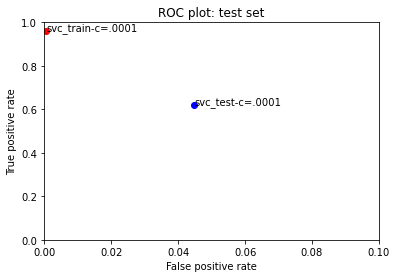

In [24]:
fits = [svc_performance_train]
#rdg_performance_train, rdf_performance_train, 

for fit in fits:
    plt.plot(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], 'ro')
    plt.text(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], fit.desc)
    


fits = [svc_performance_testc0_0001]
#svm_performance_test, lgs_performance_test, nbs_performance_test, prc_performance_test, rdg_performance_test, rdf_performance_test, 
for fit in fits:
    plt.plot(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], 'bo')
    plt.text(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], fit.desc)
plt.axis([0, .1, 0, 1])
plt.title('ROC plot: test set')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.show()

---

# <span style="color:red">SUBMISSION</span>

---

In [25]:
# read in test data for submission
# CHANGE FILE PATH and my_random_seed number (any integer other than 74 will do): 
raw_data, X_test_submission = process_raw_data(fn='C:/Users/Dallas/Desktop/Machine Learning/toxiccomments_testIter1.csv', my_random_seed=85, test=True)
print("Number of rows in the submission test set (should be 153,164): ")

FileNotFoundError: [Errno 2] File C:/Users/Dallas/Desktop/Machine Learning/toxiccomments_testIter1.csv does not exist: 'C:/Users/Dallas/Desktop/Machine Learning/toxiccomments_testIter1.csv'

---

Choose a <span style="color:red">*single*</span> model for your submission. In this code, I am choosing the Ordinary Least Squares model fit, which is in the `ols` object. But you should choose the model that is performing the best for you! 

In [ ]:
# store the id from the raw data
my_submission = pd.DataFrame(raw_data["id"])
# concatenate predictions to the id
my_submission["prediction"] = ols.predict(X_test_submission)
# look at the proportion of positive predictions
print(my_submission['prediction'].mean())

In [ ]:
raw_data.head()

In [ ]:
my_submission.head()

In [ ]:
my_submission.shape

In [ ]:
# export submission file as pdf
# CHANGE FILE PATH: 
my_submission.to_csv('/home/ec2-user/data/toxiccomments_submission.csv', index=False)

# Submit to Canvas: 1) the CSV file that was written in the previous cell and 2) the url to the repository (GitHub or other) that contains your code and documentation